# Problem 3 - Robust Unit Commitment

In [15]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

# Definition of data

In [2]:
s = slice(0, 6, None)
startup_costs = np.array([75, 100, 75, 100, 100, 125.])[s]
shutdown_costs = np.array([7.5, 10.0, 7.5, 10.0, 10.0, 12.5])[s]
running_costs = np.array([10, 5, 10, 10, 10, 10.])[s]
generation_costs = np.array([15, 20, 15, 20, 30, 25.])[s]

capacity = np.array([10, 5, 10, 10, 20, 30.])[s]
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])[s]
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])[s]

initial_state = np.array([1, 0, 0, 0, 0, 0])[s]

In [3]:
rt_bar = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
rt_hat = 0.6*np.ones_like(rt_bar)
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 3.5

In [4]:
Tup = 3
Tdown = 2

In [5]:
# %%timeit
# YOUR CODE HERE
# We recommend GLPK_MI solver
Ng = len(initial_state)  # number of traditional generators
T = len(dt)  # planning horizon
# Define variables
a = cp.Variable((Ng, T))  # rt param
b = cp.Variable((Ng, T))  # rt param 
c = cp.Variable((Ng, T))  # rt param
u = cp.Variable((Ng, T), boolean=True)  # generator is starting (flag)
v = cp.Variable((Ng, T), boolean=True)  # generator is shutting down (flag)
x = cp.Variable((Ng, T), boolean=True)  # generator is running (flag)

# problem dual variables
p1 = cp.Variable(T) 
p2 = cp.Variable(T)
# constraints dual variables
y1 = cp.Variable((Ng, T))
y2 = cp.Variable((Ng, T))
y3 = cp.Variable((Ng, T))
y4 = cp.Variable((Ng, T))
y5 = cp.Variable((Ng, T))
y6 = cp.Variable((Ng, T))
y7 = cp.Variable((Ng, T))
y8 = cp.Variable((Ng, T))

gx = cp.multiply(np.tile(capacity, (T, 1)).T, x)
rp, rm = rt_hat + rt_bar, rt_hat - rt_bar

'''
objective = cp.Minimize(
    cp.sum(startup_costs @ u + shutdown_costs @ v + running_costs @ x) 
    + np.repeat(generation_costs, T) @ c.flatten()  
    + p1 @ (rt_hat + rt_bar) + p2 @ (rt_hat - rt_bar)
)

constraints3 = [
    # 3b & linearization
    cp.sum(a, axis=0) == -1, 
    cp.sum(b, axis=0) == 0, 
    cp.sum(c, axis=0) == dt,
    # 3c & uncertainty box
    b[:,0] == 0
]

'''

### 

objective = cp.Minimize(
    cp.sum( [rp[t] * p1[t] + rm[t] * p2[t] for t in range(T)] )
    + cp.sum( [ (startup_costs[i] * u[i][t] + shutdown_costs[i] * v[i][t] + running_costs[i] * x[i][t] + generation_costs[i] * c[i][t]) 
               for i in range(Ng) for t in range(T)] )    
)

constraints2 = [
    # 2d
    x[:, :-1] - x[:, 1:] + u[:, 1:] >= 0,
    # 2e
    x[:, 1:] - x[:, :-1] + v[:, 1:] >= 0,
    # 2f
    *[x[:, t] - x[:, t-1] <= x[:, tau]
      for t in range(1, T) for tau in range(t+1, min(t + Tup, T))],
    # 2g
    *[x[:, t-1] - x[:, t] <= 1 - x[:, tau]
      for t in range(1, T) for tau in range(t+1, min(t + Tdown, T))],
    # 2h
    u[:, 0] == 0, x[:, 0] == initial_state, v[:, 0] == 0,
]

constraints3 = []

for i in range(Ng):
    constraints3.append(b[i][0] == 0)

for t in range(T):
    constraints3.append(sum([c[i][t] for i in range(Ng)]) == dt[t])
    constraints3.append(sum([b[i][t] for i in range(Ng)]) == 0)
    constraints3.append(sum([a[i][t] for i in range(Ng)]) == -1)

    
for t in range(T-1):
    constraints3.append( p1[t] - p2[t] >= sum([generation_costs[i] * (a[i][t]+b[i][t+1]) for i in range(Ng)]) )

constraints3.append( p1[T-1] - p2[T-1] >= sum([generation_costs[i] * a[i][T-1] for i in range(Ng)]) )

for i in range(Ng):
    for t in range(T):
        if t == 0:
            constraints3 += [-c[i][t] <= rp[t]*y1[i][t] + rm[t]*y2[i][t]]
            constraints3 += [c[i][t] - gx[i][t] <= rp[t]*y5[i][t] + rm[t]*y6[i][t]]
        else:
            constraints3 += [-c[i][t] <= rp[t]*y1[i][t] + rm[t]*y2[i][t] + 
                                                   rp[t-1]*y3[i][t] + rm[t-1]*y4[i][t]]
            constraints3 += [c[i][t] - gx[i][t] <= rp[t]*y5[i][t] + rm[t]*y6[i][t] + 
                                                   rp[t-1]*y7[i][t] + rm[t-1]*y8[i][t]]
        
        constraints3.append(y1[i][t] - y2[i][t] <= a[i][t])
        constraints3.append(y3[i][t] - y4[i][t] <= b[i][t])
        constraints3.append(y5[i][t] - y6[i][t] <= -a[i][t])
        constraints3.append(y7[i][t] - y8[i][t] <= -b[i][t])



constraints3 += [y1 <= 0] 
constraints3 += [y2 <= 0] 
constraints3 += [y3 <= 0] 
constraints3 += [y4 <= 0] 
constraints3 += [y5 <= 0] 
constraints3 += [y6 <= 0] 
constraints3 += [y7 <= 0] 
constraints3 += [y8 <= 0] 
constraints3 += [p1 >= 0]
constraints3 += [p2 >= 0]

problem = cp.Problem(objective, constraints2 + constraints3)
problem.solve(solver=cp.GLPK_MI, verbose=1)
print("Total cost", problem.value)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) May 20 08:49:49 PM: Your problem has 2064 variables, 1046 constraints, and 0 parameters.
(CVXPY) May 20 08:49:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 08:49:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 08:49:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 08:49:50 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) May 20 08:49:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu

In [6]:
len(constraints3)

976

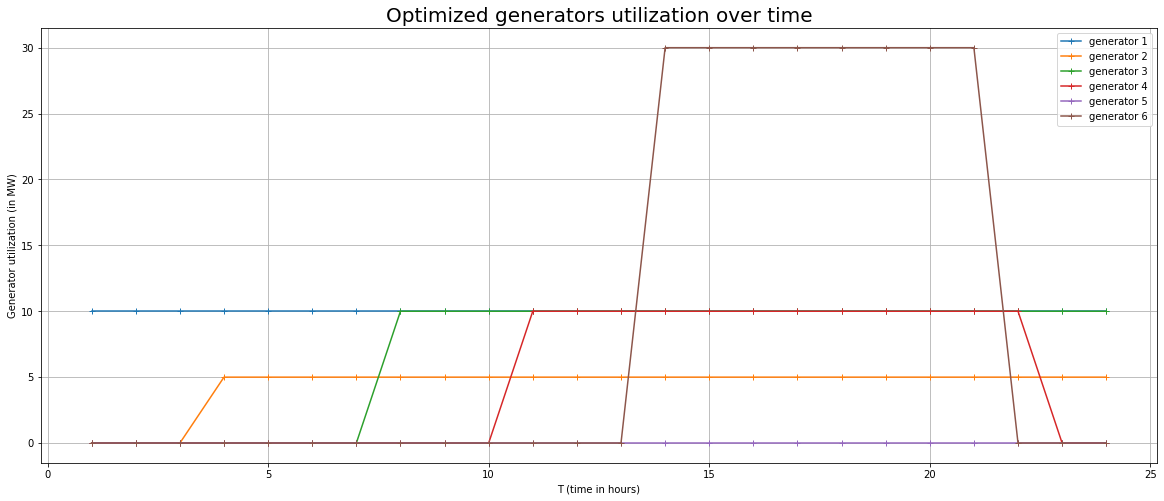

In [10]:
plt.figure(figsize=(20,8))

x_ticks = range(1, 25)

for i in range(0, len(gx.value)):
    plt.plot(x_ticks, gx.value[i], label='generator '+str(i+1), marker='+')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Optimized generators utilization over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex3.5.a.png')
plt.show()

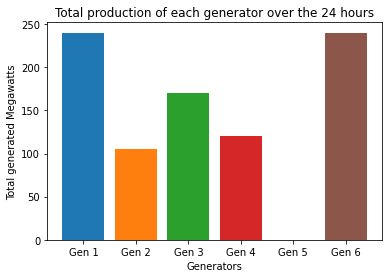

In [11]:
data = np.sum(gx.value, axis=1)

labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6']
default_numpy_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6,4))

plt.xticks(range(len(data)), labels)
plt.xlabel('Generators')
plt.ylabel('Total generated Megawatts')
plt.title('Total production of each generator over the 24 hours')
plt.bar(range(len(data)), data, color = default_numpy_colors[0:6])

plt.savefig('ex3.5.b.png')
plt.show()

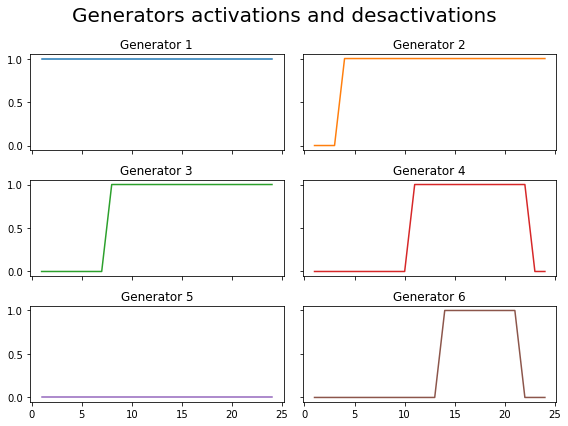

In [13]:
x_ticks = range(1, 25)

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, sharex = True, sharey = True,figsize=(8.0, 6.0))

ax11.plot(x_ticks, x.value[0], color='#1f77b4')
ax11.set_title('Generator 1')
ax12.plot(x_ticks, x.value[1], color='#ff7f0e')
ax12.set_title('Generator 2')
ax21.plot(x_ticks, x.value[2], color='#2ca02c')
ax21.set_title('Generator 3')
ax22.plot(x_ticks, x.value[3], color='#d62728')
ax22.set_title('Generator 4')
ax31.plot(x_ticks, x.value[4], color='#9467bd')
ax31.set_title('Generator 5')
ax32.plot(x_ticks, x.value[5], color='#8c564b')
ax32.set_title('Generator 6')

fig.suptitle('Generators activations and desactivations', fontsize=20)
plt.tight_layout()
plt.savefig('ex3.5.c.png')
plt.show()  